In [1]:
import itertools

import random
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
from colorspacious import cspace_converter
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
from mpltern.datasets import get_triangular_grid
import matplotlib.ticker as ticker

from scipy.spatial import distance
from cvxpy.error import SolverError
from cvxpy import ECOS, SCS
import seaborn as sns
import ot
from pgmpy import inference
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.express as px

from plotly.subplots import make_subplots
from mpltern.datasets import get_triangular_grid
import scipy.optimize as optimize
from scipy.spatial.distance import cdist
from src.examples import smokingmodels as sm
from scipy.spatial.distance import squareform,pdist
from scipy.optimize import linprog
from scipy import stats
from scipy.stats import wasserstein_distance

from IPython.utils import io
import warnings

import joblib
import modularized_utils as ut
import abstraction_metrics as ams
import matplotlib.pylab as pl

import get_results
import params

np.random.seed(0)

warnings.filterwarnings(action='ignore')
np.set_printoptions(precision=4,suppress=True)

In [2]:
def create_comb(a, b, c):
    return str(a)+'-'+str(b)+'-'+str(c)

def parse_comb(input_string):
    a, b, c = input_string.split('-')
    return [float(a), float(b), float(c)]

In [3]:
def leave_one_out_grid(pairs, dropped_pair, experiment, combination, df, cf, cota_version):
    
    omega = {}
    for pair in pairs:
        omega[pair.iota_base] = pair.iota_abst
    
    hold_pairs = pairs.copy()
   
    if dropped_pair != None:
        hold_pairs.remove(dropped_pair)
        hold_omega  = ut.drop1omega(omega, dropped_pair.iota_base)
        
    else:
        hold_omega = omega
        
    I_relevant  = list(hold_omega.keys())

    struc, tree = ut.build_poset(I_relevant)
    chains      = ut.to_chains(hold_pairs, struc)
    
    combin = parse_comb(combination)
    kk, ll, mm = combin[0], combin[1], combin[2]
    
    args   = [hold_pairs, [chains], kk, ll, mm, df, cf]
    
    if cota_version == 'avg_plan':
        get_results.results_grid_looo(args, experiment, dropped_pair)
        looo_grid_results = ut.load_grid_results_looo(experiment, combination, dropped_pair)
        
    elif cota_version == 'avg_map':
        get_results.results_grid_looo_aggregated(args, experiment, dropped_pair)
        looo_grid_results = ut.load_grid_results_looo_aggregated(experiment, combination, dropped_pair)
    
    return looo_grid_results

In [4]:
def compute_ae_grid_looo(exp, pairs, combo, metric, cost, cota_version):
    
    looo_results_grid = []
    for n in range(len(pairs)):

        results_grid = {}
        for i, pair in enumerate(pairs[n]):

            if pair.iota_base.intervention != {None: None}:
                dropped_pair = pair
            else:
                dropped_pair = None

            results_grid[dropped_pair] = leave_one_out_grid(pairs[n], dropped_pair, exp, combo, metric, cost, cota_version)

        looo_results_grid.append(results_grid)
    
    return looo_results_grid

In [5]:
def get_looo_results(maps, pairs, looo, error, cota_version):
    
    no_looo_map = maps[0][list(maps[0].keys())[0]]
    
    if cota_version == 'avg_plan':
        no_looo_map = no_looo_map[0]
    
    n_sims = len(maps)
    avg_list = []
    for n in range(n_sims):

        ae = 0
        for pair in pairs[n]:
            #print('base: ', pair.iota_base.intervention, 'abst: ', pair.iota_abst.intervention)
            if pair.iota_base.intervention == {None: None}:
                p = None
            else:
                p = pair
            
            tau_dict = maps[n][p]
            
            if cota_version == 'avg_plan':
                tau_dict = tau_dict[0]
                
            if looo == True:
                tau = ams.to_tuples(tau_dict, 'stochastic')
            else:
                tau = ams.to_tuples(no_looo_map, 'stochastic')

            pushforward = ams.stochastic_pushforward(tau, pair.base_dict, list(pair.abst_dict.keys()))
            
            if error == 'jsd':
                d = distance.jensenshannon(pushforward, pair.abst_distribution)
                ae += d
            elif error == 'wass':
                d = wasserstein_distance(pushforward, pair.abst_distribution)
                ae += d

        avg_list.append(ae/len(pairs[n]))

    return np.mean(avg_list), np.std(avg_list)

In [6]:
def run_cota(exp, pairs, metric, cost, n_grid, looo, error, cota_version):    

    track_MI = False
    if n_grid != 1:
        
        k_list, l_list, m_list = get_triangular_grid(n_grid)
        conv_combinations = []
        for elements in zip(k_list, l_list, m_list):
            kappa, lmbda, mu = elements[0], elements[1], elements[2]
            conv_combinations.append(create_comb(kappa, lmbda, mu))
            
    else:
        conv_combinations = ['1.0-0.0-0.0']

    grid_dict, stds = {}, {}
    excluded_combos     = []
    for combo in tqdm(conv_combinations):
        try:
            ms               = compute_ae_grid_looo(exp, pairs, combo, metric, cost, cota_version)
            grid_dict[combo], stds[combo] = get_looo_results(ms, pairs, looo, error, cota_version)
        except SolverError:
            print(f"SolverError occurred for combo: {combo}. Skipping this combo.")
            excluded_combos.append(combo)

    conv_combinations = [combo for combo in conv_combinations if combo not in excluded_combos]
    k_list, l_list, m_list = [], [], []
    for combo in conv_combinations:
        kappa, lmbda, mu = map(float, combo.split('-'))
        k_list.append(kappa)
        l_list.append(lmbda)
        m_list.append(mu)

    f_values    = list(grid_dict.values())
    std_values  = list(stds.values())

    data_dict = {
        'κ': k_list,
        'λ': l_list,
        'μ': m_list,
        'e(α)': f_values,
        'std': std_values
    }

    df_simplex = pd.DataFrame(data_dict)

    min_value = df_simplex['e(α)'].min()
    max_value = df_simplex['e(α)'].max()

    df_simplex['e(α)'] = (df_simplex['e(α)'] - min_value) / (max_value - min_value)
    
    sorted_simplex = df_simplex.sort_values(by='e(α)', ascending=True)
    
    return sorted_simplex

In [7]:
def get_solution(sorted_simplex, m, c, cota_version):

    mean = np.mean(list(sorted_simplex['e(α)']))
    std  = np.std(list(sorted_simplex['e(α)']))

    min_index = sorted_simplex['e(α)'].idxmin()

    min_a = sorted_simplex.loc[min_index, 'κ']
    min_b = sorted_simplex.loc[min_index, 'λ']
    min_c = sorted_simplex.loc[min_index, 'μ']

    min_value = sorted_simplex.loc[min_index, 'e(α)']
    
    lookup_values = {'κ': 1.0, 'λ': 0.0, 'μ': 0.0}

    pwise = sorted_simplex.loc[(sorted_simplex['κ'] == lookup_values['κ']) & (sorted_simplex['λ'] == lookup_values['λ']) & (sorted_simplex['μ'] == lookup_values['μ'])]

    pw_mean = pwise['e(α)'][0]
    pw_std  = pwise['std'][0]

    return min_value, min_a, min_b, min_c

# Simplex/Ternary Plot

In [27]:
def plot_simplex(df, font, colormap, num_levels, exp, metric, cost, error, n_grid):
    
    min_e_alpha_index = np.argmin(df['e(α)'])

    min_t, min_l, min_r = df.iloc[0]['κ'], df.iloc[0]['λ'], df.iloc[0]['μ']
    t, l, r, v          = df['κ'], df['λ'], df['μ'], df['e(α)']

    vmin, vmax = min(df['e(α)']), max(df['e(α)'])

    cmap = plt.get_cmap(colormap, num_levels)

    levels = np.linspace(vmin, vmax, num_levels)

    fig = plt.figure(figsize=(7, 7))
    
    ax = fig.add_subplot(1, 1, 1, projection='ternary')
    cs = ax.tricontourf(t, l, r, v, levels=levels, cmap=cmap)
    
    ax.plot([min_t], [min_l], [min_r], marker='x', color='white', markersize=10, markeredgewidth=2)
    ax.set_tlabel('(κ, λ, μ) = (1, 0, 0)')#, fontdict=font)
    ax.set_llabel('(κ, λ, μ) = (0, 1, 0)')#, fontdict=font)
    ax.set_rlabel('(κ, λ, μ) = (0, 0, 1)')#, fontdict=font)
    
    ax.tick_params(axis='both', which='major', labelsize=9, rotation=20)
    
    colorbar = fig.colorbar(cs, orientation='horizontal', shrink=0.75)
    #colorbar.set_clim(vmin=vmin, vmax=vmax)
    
    num_intervals = 5 
    locator = ticker.MaxNLocator(nbins=num_intervals)
    colorbar.locator = locator
    
    def format_func(x, _):
        return f'{x:.1f}' 
    
    colorbar.formatter = ticker.FuncFormatter(format_func)
    colorbar.update_ticks()
    
    colorbar.set_label('e(τ)', rotation=0, fontsize = 12, fontdict=font, ha='center')  
    colorbar.ax.tick_params(labelsize=9)
    
    plt.savefig(f"plots/{exp}_{metric}_{cost}_{error}_{n_grid}.png", bbox_inches='tight')
    plt.show()
    
    
    return 

In [38]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'style': 'normal',
        'size': 9,
        }

colormap = 'RdBu' #'RdBu' #'viridis'#'PuBuGn'

num_levels = 110

In [29]:
exp     = 'synth1'
metric  = 'fro'
cost    = 'Omega'
version = 'avg_plan'
n_grid  = 14

In [30]:
pairs      = ut.load_pairs(exp)
df_simplex = run_cota(exp, pairs, metric, cost, n_grid, True, 'jsd', version)

100%|█████████████████████████████████████████| 105/105 [38:45<00:00, 22.15s/it]


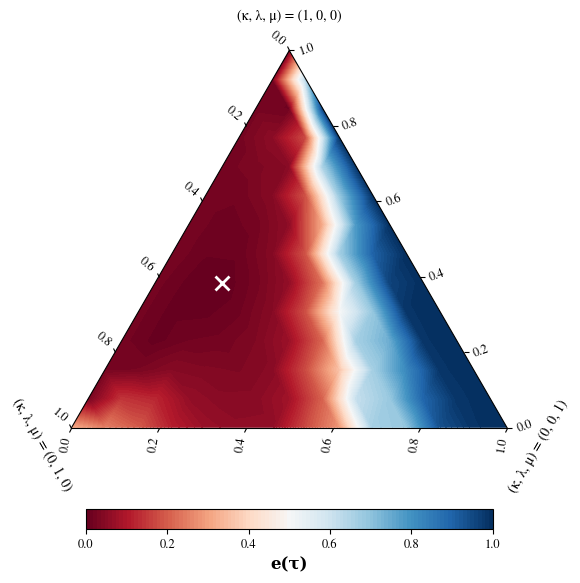

In [39]:
plot_simplex(df_simplex, font, colormap, num_levels, exp, metric, cost, 'jsd', n_grid)

# Plot cost matrices

In [9]:
import cost_functions_utils as cts

In [10]:
def get_cost_matrix(exp, cost):
    
    pairs    = ut.load_pairs(exp)
    
    if cost == 'Omega':
        mat = cts.generate_omega_cost_matrix(pairs[0])
    elif cost == 'Hamming':
        mat = cts.generate_hamming_cost_matrix(pairs[0])

    min_value = np.min(mat)
    max_value = np.max(mat)

    norm_mat = (mat - min_value) / (max_value - min_value)

    return norm_mat

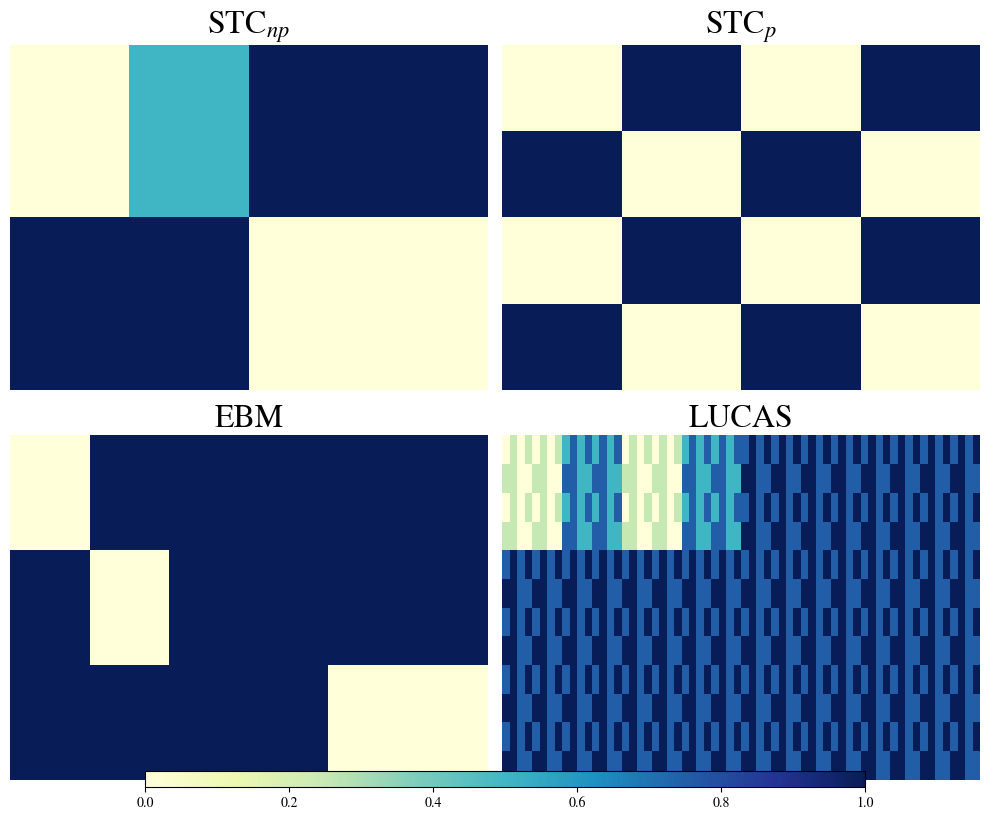

In [40]:
for cost in ['Omega']:
    
    data1 = get_cost_matrix('synth1', cost)
    data2 = get_cost_matrix('synth1T', cost)
    data3 = get_cost_matrix('battery_discrete', cost)
    data4 = get_cost_matrix('little_lucas', cost)

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Plot the first heatmap in the top-left subplot
    heatmap1 = sns.heatmap(data1, fmt=".2f", cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, ax=axes[0, 0])
    #axes[0, 0].set_title("STC_np", fontdict=title_font)
    axes[0, 0].set_title("STC$_{np}$", fontsize =23)

    # Plot the second heatmap in the top-right subplot
    heatmap2 = sns.heatmap(data2, fmt=".2f", cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, ax=axes[0, 1])
    #axes[0, 1].set_title("STC_p", fontdict=title_font)
    axes[0, 1].set_title("STC$_{p}$", fontsize =23)
    
    # Plot the fourth heatmap in the bottom-right subplot
    heatmap3 = sns.heatmap(data4, fmt=".2f", cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, ax=axes[1, 1])
    #axes[1, 1].set_title("LUCAS", fontdict=title_font)
    axes[1, 1].set_title("LUCAS", fontsize =23)

    # Plot the third heatmap in the bottom-left subplot
    heatmap4 = sns.heatmap(data3, fmt=".2f", cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, ax=axes[1, 0])
    #axes[1, 0].set_title("EBM", fontdict=title_font)
    axes[1, 0].set_title("EBM", fontsize =23)

    # Create a common colorbar based on the data of the first heatmap
    cbar_ax = fig.add_axes([0.15, 0.01, 0.72, 0.02])  # Adjust the coordinates to position the colorbar further down
    cbar = fig.colorbar(heatmap1.get_children()[0], cax=cbar_ax, orientation='horizontal')
    #cbar.set_label(labelpad=10)  # Customize the colorbar label as needed

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Show the subplots
    plt.show()